### 3体ハミルトニアン定義

In [ ]:
import itertools
import numpy as np

# ==== パラメータ設定 ====
num_orbitals = 6
num_particles = 3
delta = 1.0   # 1体項の等間隔エネルギー
v = 0.3       # 2体相互作用（ペア＋単粒子遷移含む）
w3 = 0.2      # 3体相互作用

# ==== 基底生成 ====
def generate_basis(num_orbitals, num_particles):
    basis = []
    for bits in itertools.combinations(range(num_orbitals), num_particles):
        occ = np.zeros(num_orbitals, dtype=int)
        occ[list(bits)] = 1
        basis.append(tuple(occ))
    return basis

basis = generate_basis(num_orbitals, num_particles)
dim = len(basis)

# ==== 生成消滅演算の定義 ====
def apply_annihilate(state, i):
    state = list(state)
    if state[i] == 0:
        return None, 0
    sign = (-1)**sum(state[:i])
    state[i] = 0
    return tuple(state), sign

def apply_create(state, i):
    state = list(state)
    if state[i] == 1:
        return None, 0
    sign = (-1)**sum(state[:i])
    state[i] = 1
    return tuple(state), sign

def apply_cdag_c(state, i, j):
    """c_i† c_j"""
    s1, sign1 = apply_annihilate(state, j)
    if s1 is None:
        return None, 0
    s2, sign2 = apply_create(s1, i)
    if s2 is None:
        return None, 0
    return s2, sign1 * sign2

# ==== 1体ハミルトニアン ====
H1 = np.zeros((dim, dim))
for p, s in enumerate(basis):
    for i, occ in enumerate(s):
        if occ == 1:
            energy = delta * (i // 2)  # 各2縮退レベルごとに等間隔
            H1[p, p] += energy

# ==== 2体ハミルトニアン（改訂版）====
pairs = [(0, 1), (2, 3), (4, 5)]
H2 = np.zeros((dim, dim))

def find_pair_and_single(state):
    """3粒子状態から (pair_index, single_orbital) を特定"""
    for p_idx, (a, b) in enumerate(pairs):
        if state[a] == 1 and state[b] == 1:
            s = [i for i in range(len(state)) if state[i] == 1 and i not in (a, b)][0]
            return p_idx, s
    return None, None

# すべてのペア・単粒子遷移を許す
for i, bra in enumerate(basis):
    p_bra, s_bra = find_pair_and_single(bra)
    if p_bra is None:
        continue  # ペアがない状態は作用しない

    for j, ket in enumerate(basis):
        p_ket, s_ket = find_pair_and_single(ket)
        if p_ket is None:
            continue

        # ペアと単粒子の両方が遷移できる
        # 全結合を許して同一強度v
        H2[i, j] += v



# ==== 3体ハミルトニアン（変更なし）====
triplets = [(0,1,2), (1,2,3), (2,3,4), (3,4,5)]
H3 = np.zeros((dim, dim))

for T1 in triplets:
    for T2 in triplets:
        for i, s in enumerate(basis):
            if all(s[k] == 1 for k in T2):
                s_new = list(s)
                sign = 1
                # アニヒレート
                for k in reversed(T2):
                    s_new, sgn = apply_annihilate(s_new, k)
                    if s_new is None:
                        break
                    sign *= sgn
                if s_new is None:
                    continue
                # クリエイト
                for k in T1:
                    s_new, sgn = apply_create(s_new, k)
                    if s_new is None:
                        break
                    sign *= sgn
                if s_new is None:
                    continue
                s_new = tuple(s_new)
                if s_new in basis:
                    j = basis.index(s_new)
                    H3[i, j] += w3 * sign

# ==== 総ハミルトニアン ====
H = H1 + H2 + H3
H = (H + H.conj()) / 2  # Hermitian化

# ==== 結果表示 ====
np.set_printoptions(precision=2, suppress=True)
print("Hamiltonian matrix (dim={}):".format(dim))

# ==== 固有値 ====
eigvals, _ = np.linalg.eigh(H)
print("\nEigenvalues:")
print(np.round(eigvals, 4))

print("\nNonzero elements in H2:", np.count_nonzero(H2))

Hamiltonian matrix (dim=20):

Eigenvalues:
[1.06 1.23 2.   2.   2.14 2.68 3.   3.   3.   3.   3.   3.   3.   3.
 4.   4.   4.14 4.62 5.11 7.41]

Nonzero elements in H2: 144


### QPE

In [ ]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import UnitaryGate, QFT, StatePreparation
from qiskit_aer import Aer

n_sys = 5
dim = len(basis)
evals, evecs = np.linalg.eigh(H)
eps = np.arange(num_orbitals) * delta
n_qubits = 8

def V_embed(tau, Emin_s):
    phases = np.exp(-1j * (evals - Emin_s) * tau)
    U20 = evecs @ np.diag(phases) @ evecs.conj().T
    U32 = np.eye(2**n_sys, dtype=complex)
    U32[:dim, :dim] = U20
    return UnitaryGate(U32, label="V")

def make_prep_hf_from_basis(basis, eps=None, hf_idx=None, n_sys=5):
    dim = len(basis)
    if hf_idx is None:
        e_cfg = [np.dot(np.array(s), np.array(eps)) for s in basis]
        hf_idx = int(np.argmin(e_cfg))
    psi20 = np.zeros(dim, dtype=complex); psi20[hf_idx] = 1.0
    psi32 = np.zeros(2**n_sys, dtype=complex); psi32[:dim] = psi20
    return StatePreparation(psi32), hf_idx

def qpe_spectrum(H_evals, num_eval_qubits=16, shots=8192,
                 psi_prep=None, Emin=None, Emax=None, pad_frac=0.02):
    if Emin is None: Emin = float(np.min(H_evals))
    if Emax is None: Emax = float(np.max(H_evals))
    dE = Emax - Emin
    Emin_s = Emin - 0.5*pad_frac*dE
    Emax_s = Emax + 0.5*pad_frac*dE
    dE_s = Emax_s - Emin_s

    tau = 2*np.pi / dE_s

    qr_anc = QuantumRegister(num_eval_qubits, "anc")
    qr_sys = QuantumRegister(n_sys, "sys")
    cr = ClassicalRegister(num_eval_qubits, "c")
    qc = QuantumCircuit(qr_anc, qr_sys, cr)
    if psi_prep is not None:
        qc.append(psi_prep, qr_sys)
    qc.h(qr_anc)

    for k in range(num_eval_qubits):
        Vk = V_embed(tau * (2**k), Emin_s).control(1)
        qc.append(Vk, [qr_anc[k], *qr_sys])

    qc.append(QFT(num_eval_qubits, do_swaps=True).inverse(), qr_anc)
    qc.measure(qr_anc, cr)

    backend = Aer.get_backend("aer_simulator")
    res = backend.run(transpile(qc, backend), shots=shots).result()
    counts = res.get_counts()

    spectrum = []
    N = 2**num_eval_qubits

    def invert_bits(b: str) -> str:
        return ''.join('1' if ch == '0' else '0' for ch in b)

    for b, c in counts.items():
        b = invert_bits(b)
        k = int(b, 2)
        phi = k / N                              
        E = Emin_s + dE_s * phi                  
        p = c / shots
        spectrum.append((E, p, b))
    spectrum.sort(key=lambda x: x[0])

    return {
        "Emin": Emin, "Emax": Emax,
        "Emin_s": Emin_s, "Emax_s": Emax_s, "tau": tau,
        "counts": counts, "spectrum": spectrum, "circuit": qc
    }

prep_hf, hf_idx = make_prep_hf_from_basis(basis, eps=eps, n_sys=n_sys)
out = qpe_spectrum(evals, num_eval_qubits=n_qubits, shots=10000000, psi_prep=prep_hf, pad_frac=1.03)
print("τ_QPE:", out["tau"], "Scaled E-range:", (out["Emin_s"], out["Emax_s"]))
print("top lines of spectrum (E, prob, bitstring):")
for E, p, b in out["spectrum"][:10]:
    print(f"{E:.6f}", f"{p:.4e}", b)


/tmp/ipykernel_825358/364238597.py:51: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc.append(QFT(num_eval_qubits, do_swaps=True).inverse(), qr_anc)


τ_QPE: 0.4877770872409987 Scaled E-range: (-2.203841706162218, 10.677422034041342)
top lines of spectrum (E, prob, bitstring):
-2.203842 9.7200e-05 000000
-2.002572 1.0610e-04 000001
-1.801302 1.2070e-04 000010
-1.600032 1.3240e-04 000011
-1.398763 1.4790e-04 000100
-1.197493 1.8010e-04 000101
-0.996223 2.1040e-04 000110
-0.794953 2.5720e-04 000111
-0.593684 3.1810e-04 001000
-0.392414 4.1700e-04 001001


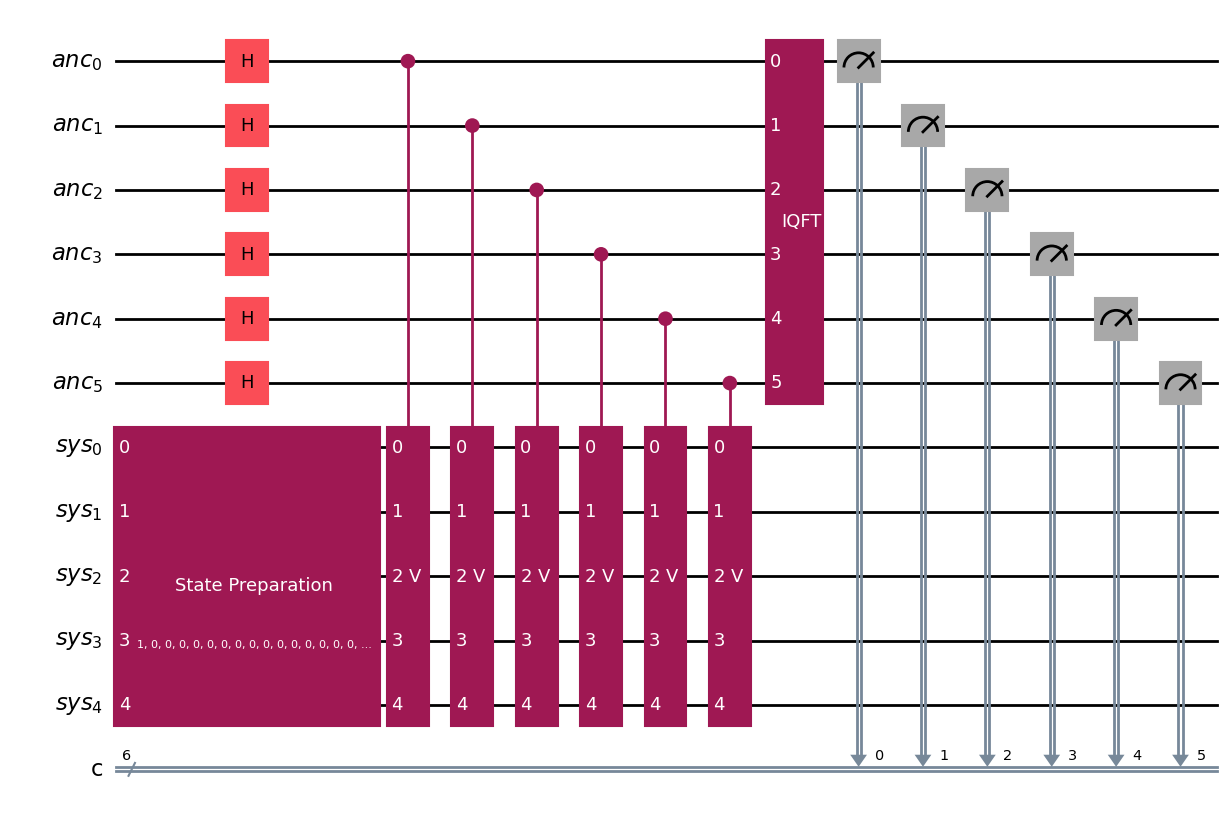

In [ ]:
out["circuit"].draw(
    output="mpl",
    fold=-1
)

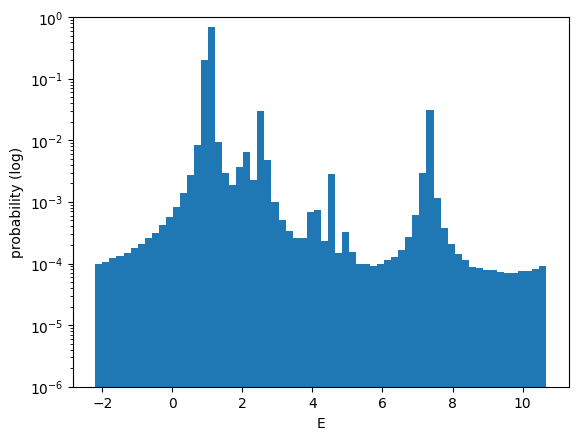

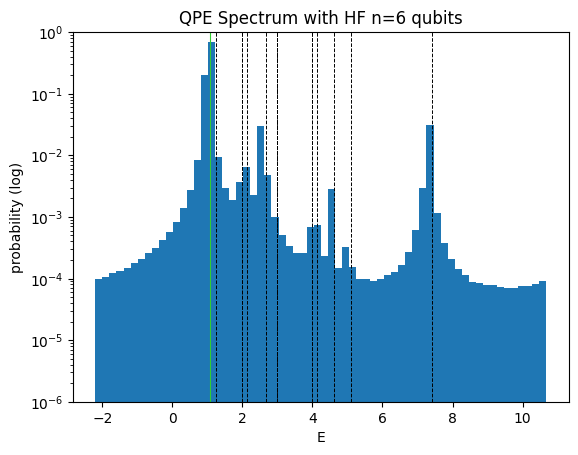

In [ ]:
E_vals = [E for E, p, b in out["spectrum"]]
P_vals = [p for E, p, b in out["spectrum"]]

import matplotlib.pyplot as plt
bin_w = (out["Emax_s"]-out["Emin_s"]) / (2**n_qubits)

plt.bar(E_vals, P_vals, width=bin_w, align="edge")
plt.yscale("log")
plt.ylim(1e-6, 1e0)
plt.xlabel("E"); plt.ylabel("probability (log)")
plt.show()

for i, e in enumerate(evals):
    if i == 0:
        plt.axvline(e, color="limegreen", linestyle="-", linewidth=0.8, label="Exact GS")
    else:
        plt.axvline(e, color="black", linestyle="--", linewidth=0.7)

plt.title(f"QPE Spectrum with HF n={n_qubits} qubits")
plt.bar(E_vals, P_vals, width=bin_w, align="edge")
plt.yscale("log")
plt.ylim(1e-6, 1e0)
plt.xlabel("E"); plt.ylabel("probability (log)")
plt.show()